In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split
from pyspark.sql.types import *


## Task 1 

### Streaming from TCP Socket


In [2]:
spark = SparkSession.builder.appName("Spark Stream").getOrCreate()
df = spark \
    .readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 12345) \
    .load()


### Print Schema

In [3]:
df.printSchema()


root
 |-- value: string (nullable = true)



### After processing, you can write the DataFrame to console.

In [4]:
df.writeStream.format("console").start()


## Task 2

let’s create a streaming DataFrame that represents text data received from a server listening on localhost:9999, and transform the DataFrame to calculate word counts.

### Create DataFrame representing the stream of input lines from connection to localhost:9999


In [5]:
spark = SparkSession.builder.appName("Sructured Streaming").getOrCreate()
lines = spark.readStream.format('socket') \
    .option('host', 'localhost') \
    .option('port', 9999) \
    .load()


### Split the lines into words


In [6]:
words = lines.select(explode(split(lines.value, ' ')).alias('word'))


### Generate running word count


In [7]:
df_wordCounts = words.groupBy("word").count()


### Start running the query that prints the running counts to the console


In [8]:
df_wordCounts \
    .writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()


### Read csv file "test1.csv"

In [9]:
userSchema = StructType().add("Name", "string").add(
    "Departments", "string").add("salary", "integer")
df = spark \
    .readStream \
    .option("sep", ",") \
    .schema(userSchema) \
    .csv("test3.csv")


### Writing Spark Streaming to Console


In [10]:
df.writeStream \
    .format("console") \
    .start()


## Task 3 

#### Creat GraphFrames
Users can create GraphFrames from vertex and edge DataFrames.

Vertex DataFrame: A vertex DataFrame should contain a special column named "id" which specifies unique IDs for each vertex in the graph.
Edge DataFrame: An edge DataFrame should contain two special columns: "src" (source vertex ID of edge) and "dst" (destination vertex ID of edge).
Both DataFrames can have arbitrary other columns. Those columns can represent vertex and edge attributes.

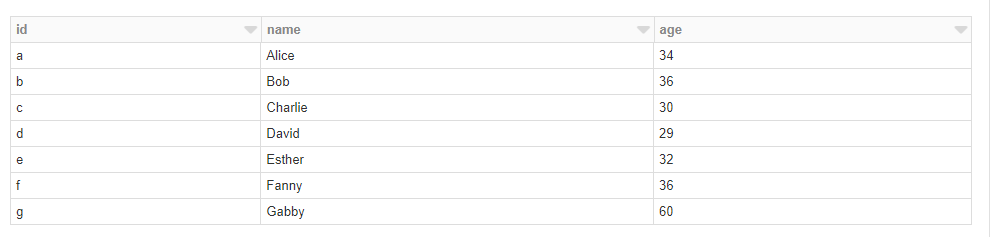

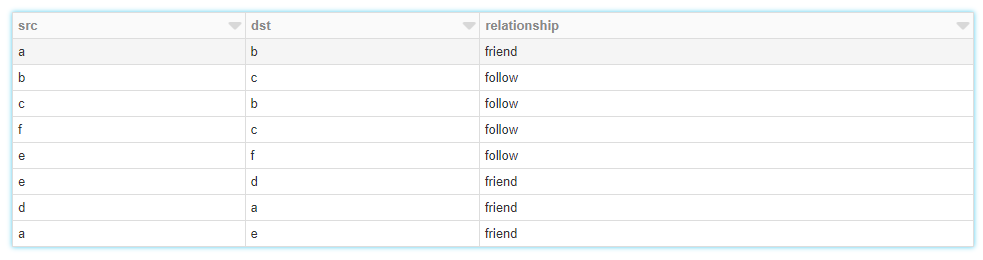

In [11]:
spark = SparkSession.builder.appName('graphframes').getOrCreate()
spark.sparkContext.addPyFile(
    "/opt/spark/jars/graphframes-0.8.2-spark3.0-s_2.12.jar")


In [12]:
from graphframes import *
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession


### Create a graph from these vertices and these edges:

In [13]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

vertices = spark.createDataFrame([
    ('a', 'Alica', 34),
    ('b', 'Bob', 36),
    ('c', 'Chalie', 30),
    ('d', 'David', 29),
    ('e', 'Esther', 32),
    ('f', 'Fanny', 36),
    ('g', 'Gabby', 60),
], [
    "id", "name", "age"
])

edges = spark.createDataFrame([
    ('a', 'b', 'friend'),
    ('b', 'c', 'follow'),
    ('c', 'b', 'follow'),
    ('f', 'c', 'follow'),
    ('e', 'f', 'follow'),
    ('e', 'd', 'friend'),
    ('d', 'a', 'friend'),
    ('a', 'e', 'friend'),
], [
    "src", "dst", "relationship"
])

graph = GraphFrame(vertices, edges)


### Display vertices

In [14]:
vertices.show()


+---+------+---+
| id|  name|age|
+---+------+---+
|  a| Alica| 34|
|  b|   Bob| 36|
|  c|Chalie| 30|
|  d| David| 29|
|  e|Esther| 32|
|  f| Fanny| 36|
|  g| Gabby| 60|
+---+------+---+



### Display edges

In [15]:
edges.show()


+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
+---+---+------------+



### Display inDegrees


In [16]:
graph.inDegrees.show()


+---+--------+
| id|inDegree|
+---+--------+
|  f|       1|
|  e|       1|
|  d|       1|
|  c|       2|
|  b|       2|
|  a|       1|
+---+--------+



### Display the outgoing degree of the vertices:



In [17]:
graph.outDegrees.show()


+---+---------+
| id|outDegree|
+---+---------+
|  f|        1|
|  e|        2|
|  d|        1|
|  c|        1|
|  b|        1|
|  a|        2|
+---+---------+



### Display the degree of the vertices:



In [19]:
graph.degrees.show()


+---+------+
| id|degree|
+---+------+
|  f|     2|
|  e|     3|
|  d|     2|
|  c|     3|
|  b|     3|
|  a|     3|
+---+------+



### Find the age of the youngest person in the graph

In [31]:
graph.vertices.groupBy().min("age").show()


+--------+
|min(age)|
+--------+
|      29|
+--------+



### Count the number of 'follow' relationships in the graph:

In [35]:
graph.edges.filter(condition="relationship = 'follow'").count()


4

### Motif finding


Search for pairs of vertices with edges in both directions between them.

In [36]:
graph.find("(a)-[e]->(b); (b)-[e2]->(a)").show()


+---------------+--------------+---------------+--------------+
|              a|             e|              b|            e2|
+---------------+--------------+---------------+--------------+
|[c, Chalie, 30]|[c, b, follow]|   [b, Bob, 36]|[b, c, follow]|
|   [b, Bob, 36]|[b, c, follow]|[c, Chalie, 30]|[c, b, follow]|
+---------------+--------------+---------------+--------------+



find all the reciprocal relationships in which one person is older than 30:

In [37]:
graph.find("(a)-[e]->(b); (b)-[e2]->(a)").filter("b.age > 30").show()


+---------------+--------------+------------+--------------+
|              a|             e|           b|            e2|
+---------------+--------------+------------+--------------+
|[c, Chalie, 30]|[c, b, follow]|[b, Bob, 36]|[b, c, follow]|
+---------------+--------------+------------+--------------+



### Explore some patterns from your choice using Motifs

In [38]:
graph.find(
    "(a)-[e]->(b); (b)-[e2]->(c); (c)-[e3]->(d)").select('a', 'b', 'c', 'd').show()


+---------------+---------------+---------------+---------------+
|              a|              b|              c|              d|
+---------------+---------------+---------------+---------------+
| [d, David, 29]| [a, Alica, 34]|[e, Esther, 32]| [f, Fanny, 36]|
|[e, Esther, 32]| [d, David, 29]| [a, Alica, 34]|[e, Esther, 32]|
| [d, David, 29]| [a, Alica, 34]|[e, Esther, 32]| [d, David, 29]|
| [a, Alica, 34]|[e, Esther, 32]| [f, Fanny, 36]|[c, Chalie, 30]|
| [f, Fanny, 36]|[c, Chalie, 30]|   [b, Bob, 36]|[c, Chalie, 30]|
|   [b, Bob, 36]|[c, Chalie, 30]|   [b, Bob, 36]|[c, Chalie, 30]|
| [d, David, 29]| [a, Alica, 34]|   [b, Bob, 36]|[c, Chalie, 30]|
|[e, Esther, 32]| [f, Fanny, 36]|[c, Chalie, 30]|   [b, Bob, 36]|
|[c, Chalie, 30]|   [b, Bob, 36]|[c, Chalie, 30]|   [b, Bob, 36]|
| [a, Alica, 34]|   [b, Bob, 36]|[c, Chalie, 30]|   [b, Bob, 36]|
|[e, Esther, 32]| [d, David, 29]| [a, Alica, 34]|   [b, Bob, 36]|
| [a, Alica, 34]|[e, Esther, 32]| [d, David, 29]| [a, Alica, 34]|
+---------